# Setup

In [ ]:
import os
import pandas as pd
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
client = bigquery.Client()
table_ref = client.dataset("benchmarks").table("opcode_benchmarks")

In [ ]:
%%bigquery benchmarks --project REDACTED
SELECT
  *
FROM `REDACTED`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery historical_opcode_usage --project REDACTED
with a as (
select
a.program_name,
a.func_name,
a.transition_id,
a.timestamp,
b.opcode,
b.count
from  `REDACTED` a join `REDACTED` b on a.program_name = b.program_name and a.func_name = b.func_name where opcode != '"')
select opcode, sum(count) as count from a group by opcode order by count desc


Query is running:   0%|          |

Downloading:   0%|          |

# Usage Trends

## Historical Finalize Scope Opcode Usage

The figure below plots historical opcode usage over all datatypes from the genesis block of Testnet3 to the current time.

### Key Observations

- **High Set/Get Load:** Mapping sets & gets are at or close to an order of magnitude more popular than any other opcode. This motivates examining set/get performance of mappings when they are at high number of entries as this could become a future performance bottleneck
- **Popular Hash Operations:** BHP hashing operations are called often. Users will likely to continue to desire to use hash functions in finalize scopes, which if included in popular programs, may lead to many millisecond long finalize scope re-executions in most blocks (or seconds-long executions during DoS attacks)



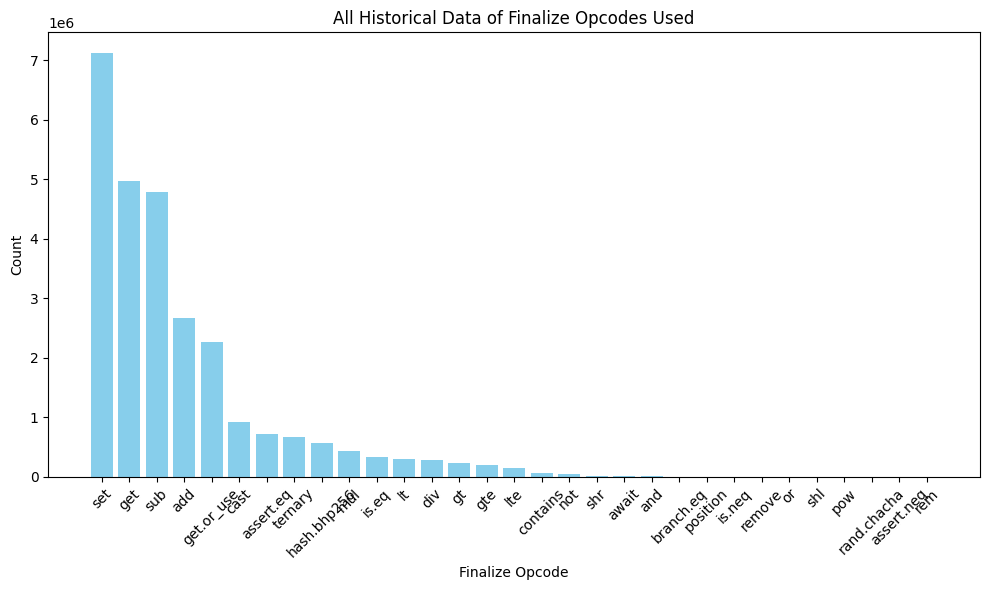

In [ ]:
# Bar chart of historical finalize opcode usage
plt.figure(figsize=(10, 6))
plt.bar(historical_opcode_usage['opcode'], historical_opcode_usage['count'], color='skyblue')

# Add labels and title
plt.xlabel('Finalize Opcode')
plt.ylabel('Count')
plt.title('All Historical Data of Finalize Opcodes Used')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit in the figure
plt.show()


# Performance Trends

## Performance: Arithmetic Operations Using Primitive Types

Unsurprisingly, primitive arithmetic operations between primitive types makeup the bulk of finalize operation usage. Inuitively they should be priced the lowest, but it's worth noting performance trends in considering the price

### Key observations

- **Linear Runtime:** As the number of operations increase, the runtime scales linearly.

- **Neglible Performance Difference Between Operand Types:** The graphs below illustrate that for many primitive operations the largest differences are close to 1 microsecond.


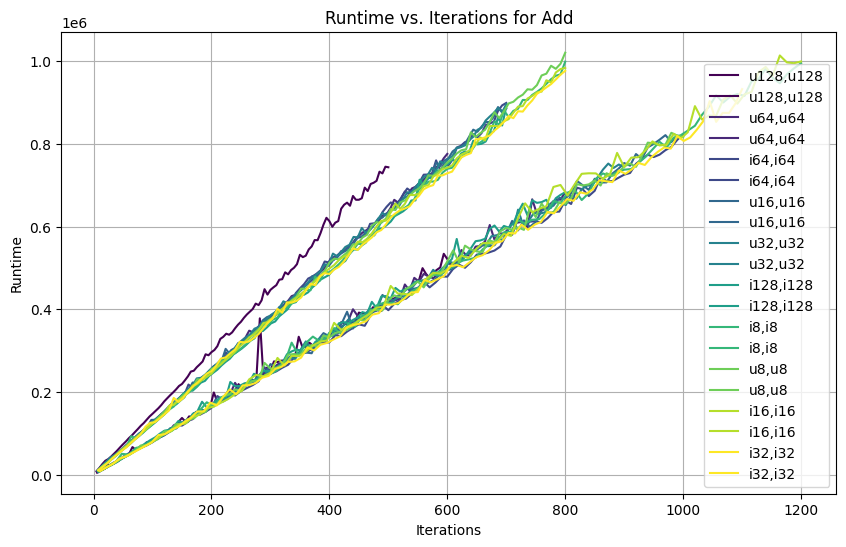

In [ ]:
selected_opcode = 'Add'  # Replace with your desired opcode

# Filter the DataFrame to select rows with the specified opcode
filtered_data = benchmarks[benchmarks['opcode'] == selected_opcode]

# Get unique datatypes in the filtered data
unique_datatypes = filtered_data['input_datatype_name'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_datatypes)))

plt.figure(figsize=(10, 6))
for i, datatype in enumerate(unique_datatypes):
    subset = filtered_data[filtered_data['input_datatype_name'] == datatype]
    for _, row in subset.iterrows():
        sample = row['sample']
        plt.plot(sample['iters'], sample['times'], label=datatype, color=colors[i])

# Customize the plot
plt.title(f'Runtime vs. Iterations for {selected_opcode}')
plt.xlabel('Iterations')
plt.ylabel('Runtime')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



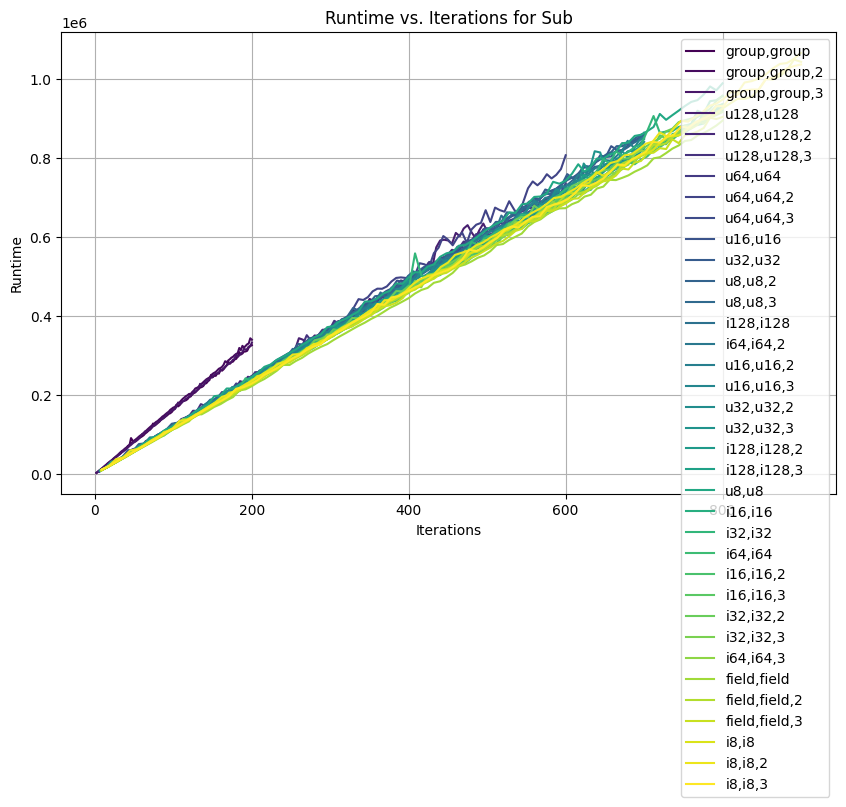

In [ ]:
selected_opcode = 'Sub'  # Replace with your desired opcode

# Filter the DataFrame to select rows with the specified opcode
filtered_data = benchmarks[benchmarks['opcode'] == selected_opcode]

# Get unique datatypes in the filtered data
unique_datatypes = filtered_data['input_datatype_name'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_datatypes)))

plt.figure(figsize=(10, 6))
for i, datatype in enumerate(unique_datatypes):
    subset = filtered_data[filtered_data['input_datatype_name'] == datatype]
    for _, row in subset.iterrows():
        sample = row['sample']
        plt.plot(sample['iters'], sample['times'], label=datatype, color=colors[i])

# Customize the plot
plt.title(f'Runtime vs. Iterations for {selected_opcode}')
plt.xlabel('Iterations')
plt.ylabel('Runtime')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


## Performance: Hash Operations

Hash operations provide the largest performance burden and unlike primitive operations, have runtimes which increase sharply for complex inputs. They are currently priced only on opcode (not on inputs) which presents an issue given there can be up to U16::MAX of them in a single finalize block. This presents an easy DoS vector currently for increasing block times and inducing failure modes.

### Performance
The graph below shows BHP512 execution times for primitive types and nested array types (the largest input being of type `[[[field; 12u32]; 12u32; 12u32]` which is close to the maximum input size of `U16:MAX` bytes).

The BHP512 hash for primitives hover around 0.05 milliseconds per hash operations, but an input of `[[[field; 12u32]; 12u32; 12u32]` is nearly 1.4 milliseconds per hash, leading to an easy DoS vector under current pricing.

### Key Observations
- **Complex Inputs Cause Heavy Performance Hits:** Inputs which involve nested structs or nested arrays can easily move into milliseconds per operation. If maxed out, block times could be drawn into minutes using a few thousand credits.

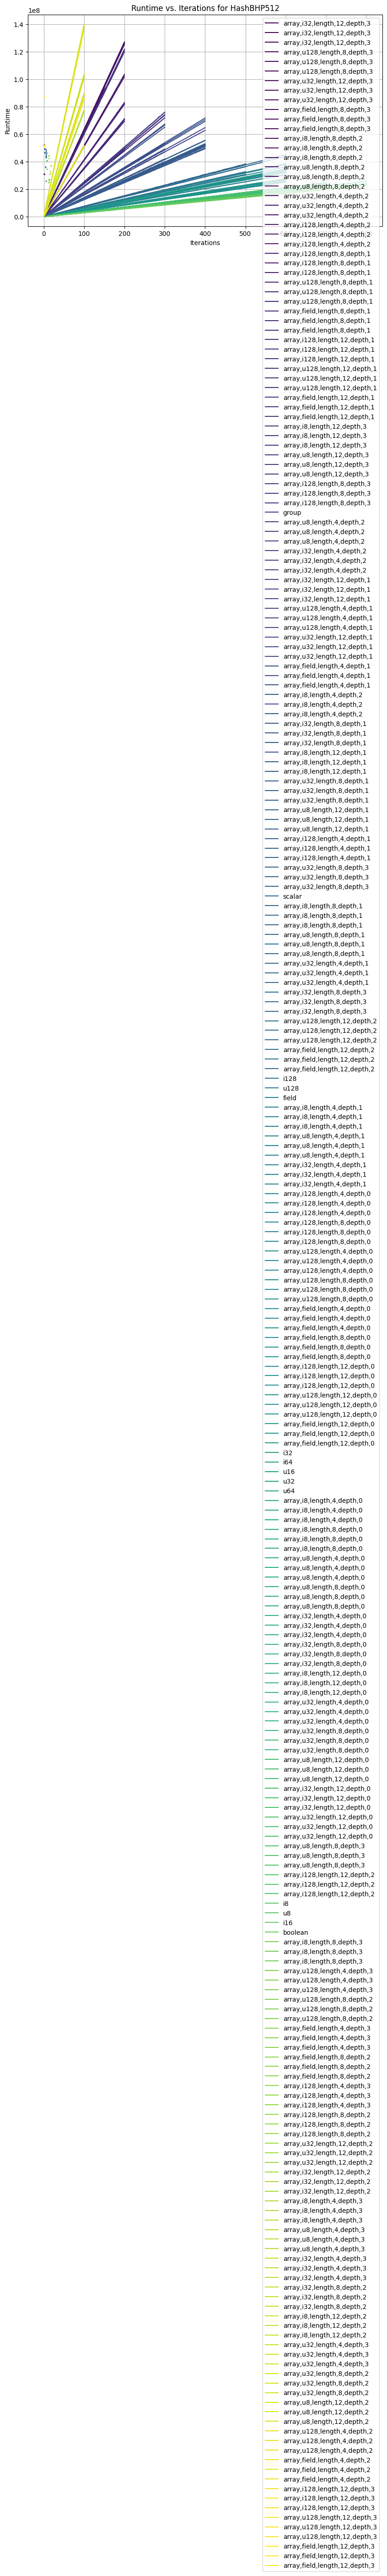

In [ ]:
selected_opcode = 'HashBHP512'  # Replace with your desired opcode

# Filter the DataFrame to select rows with the specified opcode
filtered_data = benchmarks[benchmarks['opcode'] == selected_opcode]

# Get unique datatypes in the filtered data
unique_datatypes = filtered_data['input_datatype_name'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_datatypes)))

plt.figure(figsize=(10, 6))
for i, datatype in enumerate(unique_datatypes):
    subset = filtered_data[filtered_data['input_datatype_name'] == datatype]
    for _, row in subset.iterrows():
        sample = row['sample']
        plt.plot(sample['iters'], sample['times'], label=datatype, color=colors[i])

# Customize the plot
plt.title(f'Runtime vs. Iterations for {selected_opcode}')
plt.xlabel('Iterations')
plt.ylabel('Runtime')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

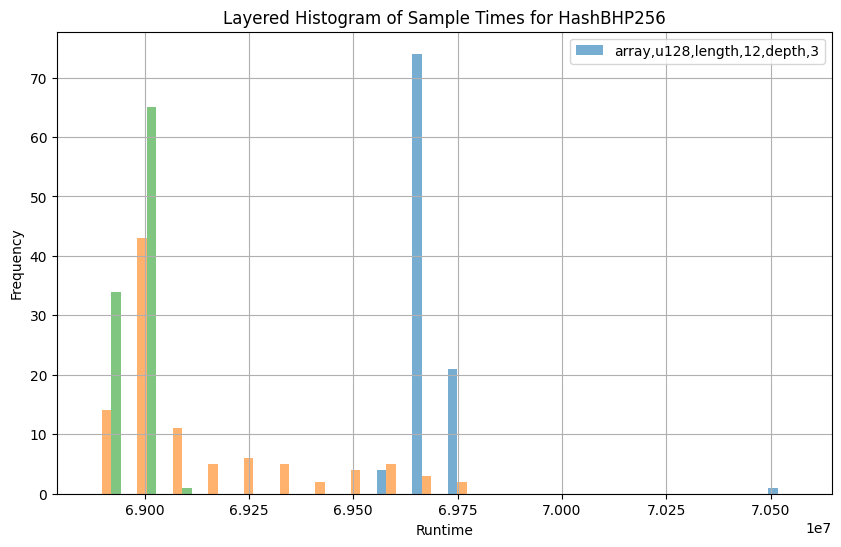

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have your DataFrame named 'df' with the given structure

# Select the opcode and datatype you want to plot
selected_opcode = 'HashBHP256'  # Replace with your desired opcode
selected_datatypes = ["array,u128,length,12,depth,3",
                     ]  # Replace with your desired datatype

# Filter the DataFrame to select rows with the specified opcode and datatype
filtered_data = benchmarks[(benchmarks['opcode'] == selected_opcode) & (benchmarks['input_datatype_name'].isin(selected_datatypes))]
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_datatypes)))
plt.figure(figsize=(10, 6))
# Create a histogram for each selected datatype and overlay them
for i, datatype in enumerate(selected_datatypes):
    subset = filtered_data[filtered_data['input_datatype_name'] == datatype]
    sample_times = subset['sample'].apply(lambda x: x['times'])
    plt.hist(
        sample_times,
        bins=20,
        alpha=0.6,  # Adjust the transparency of the bars
        label=datatype
    )

# Customize the plot
plt.title(f'Layered Histogram of Sample Times for {selected_opcode}')
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



0
['array,field,length,12,depth,3']


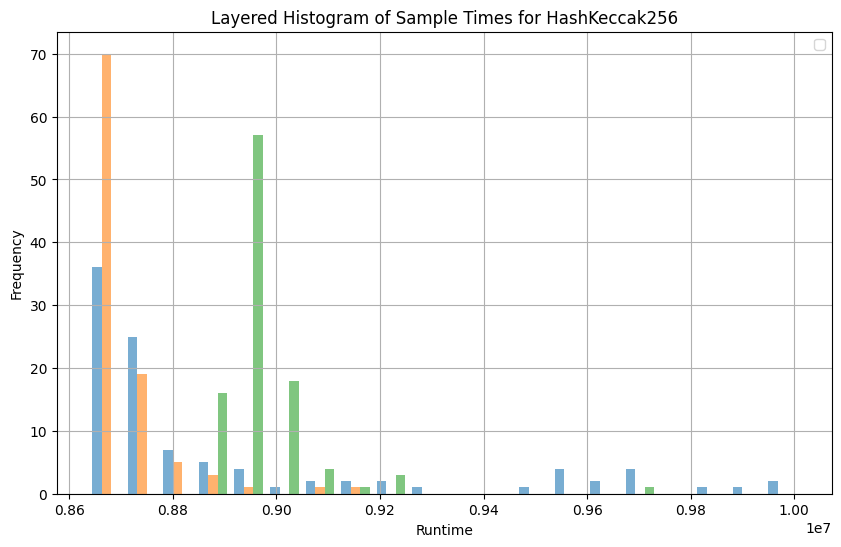

In [ ]:

import matplotlib.pyplot as plt

# Assuming you have your DataFrame named 'df' with the given structure

# Select the opcode and datatype you want to plot
selected_opcode = 'HashKeccak256'  # Replace with your desired opcode
selected_datatypes = [	"array,field,length,12,depth,3"
                     ]  # Replace with your desired datatype

# Filter the DataFrame to select rows with the specified opcode and datatype
filtered_data = benchmarks[(benchmarks['opcode'] == selected_opcode) & (benchmarks['input_datatype_name'].isin(selected_datatypes))]
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_datatypes)))
plt.figure(figsize=(10, 6))
# Create a histogram for each selected datatype and overlay them
for i, datatype in enumerate(selected_datatypes):
    print(i)
    print(selected_datatypes)
    subset = filtered_data[filtered_data['input_datatype_name'] == datatype]
    sample_times = subset['sample'].apply(lambda x: x['times'])
    plt.hist(
        sample_times,
        bins=20,
        alpha=0.6,  # Adjust the transparency of the bars
    )

# Customize the plot
plt.title(f'Layered Histogram of Sample Times for {selected_opcode}')
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

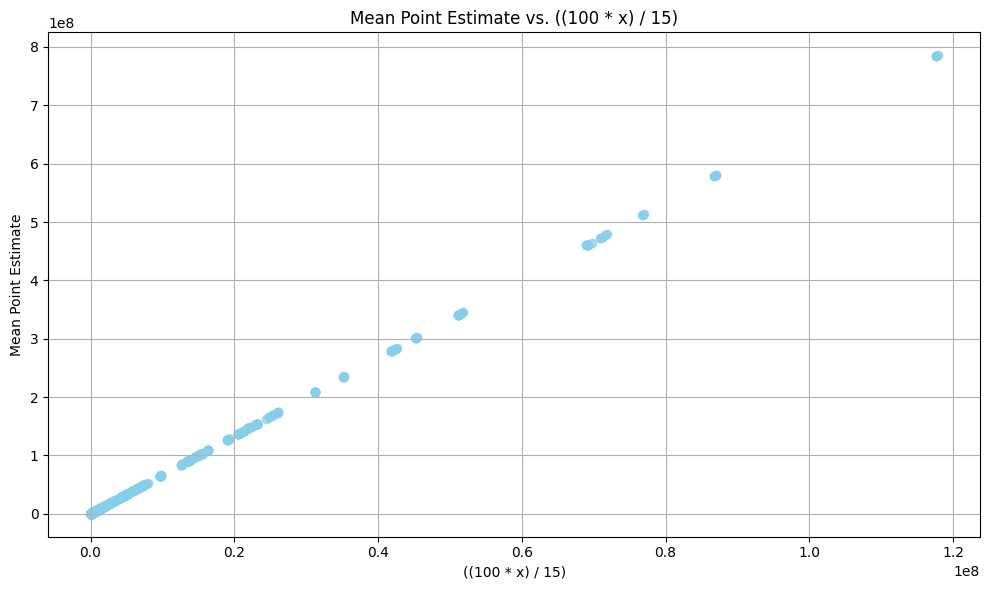

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your DataFrame named 'benchmarks' with the given structure

# Define a function to extract the "point_estimate" from the dictionary
def extract_point_estimate(row):
    return row['mean']['point_estimate']

# Apply the function to create a new column with the extracted "point_estimate"
benchmarks['point_estimate'] = benchmarks.apply(extract_point_estimate, axis=1)

# Calculate ((100 * x) / 15) for each "point_estimate"
benchmarks['fee'] = (100 * benchmarks['point_estimate']) / 15

# Create a plot
plt.figure(figsize=(10, 6))
plt.scatter(benchmarks['point_estimate'], benchmarks['fee'], c='skyblue', alpha=0.7)

# Customize the plot
plt.title('Mean Point Estimate vs. ((100 * x) / 15)')
plt.xlabel('((100 * x) / 15)')
plt.ylabel('Mean Point Estimate')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


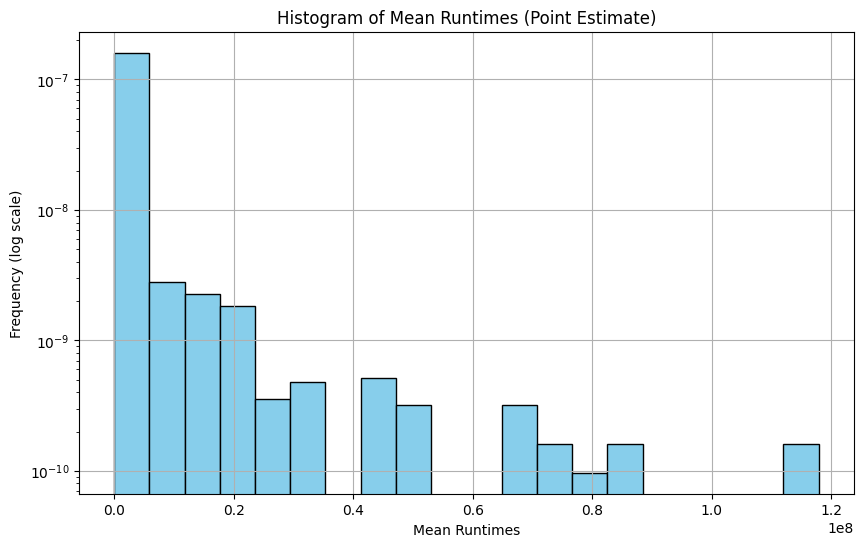

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your DataFrame named 'benchmarks' with the given structure

# Extract the "point_estimate" column for all mean runtimes
point_estimates = benchmarks['point_estimate']

# Create a histogram of the "point_estimate" values with a logarithmic y-axis scale
plt.figure(figsize=(10, 6))
plt.hist(point_estimates, bins=20, color='skyblue', edgecolor='black', density=True)
plt.yscale('log')  # Apply a logarithmic y-axis scale

# Customize the plot
plt.title('Histogram of Mean Runtimes (Point Estimate)')
plt.xlabel('Mean Runtimes')
plt.ylabel('Frequency (log scale)')

# Show the plot
plt.grid(True)
plt.show()


# Pricing

The above analysis shows that some opcodes vary greatly in runtime given specific operands. Thus price should be a function of both opcode and operands.

## Definitions

### 1. A Measurable Set of All Opcodes & Operands

For each Aleo opcode, there exists a finite set of unique operand types which it can be applied to. We can express the entire possible set of opcode & operand types as:

***
$\forall \text{opcode} \in \text{Aleo Opcodes}, \exists! \text{input_operand_types} \subseteq \text{possible_operand_types} : \{ \text{opcode}, \text{input_operand_types} \}$
***


### 2. Runtime Measure

If we let $\text{OP}$ be the set of all unique tuples of opcodes \& operands $\{ \text{opcode}, \{\text{operand_types}\} \}$. We can define a positive real-valued function E that assigns a runtime measurement to each tuple in $OP$.

****
$\exists\, E : \text{OP} \to \mathbb{t}^+$
****

This function could be built as a lookup table from benchmarks of opcodes over their possible operands.

### 3. Byte Measure (as a proxy for runtime)

One problem with using runtime directly is that it is highly variable across the hardware nodes in the validator set may be running. A more consistent  which correlates strongly with the runtime and is directly measurable is the # of bytes in the input.

We can use the same measurable set as above, but instead put a byte measure on it.

****
$\exists\, E : \text{OP} \to \mathbb{bytes}^+$
****

Given this quantity is always calculable from discrete types, it allows us to easily apply an appropriate pricing equation

### 4. Pricing Equation

This lead to a pricing equation that is directly calculable with the byte input.

***
$P(bytes) =  fee_{microcredits}$
***

And implicitly as a function of the opcode & inputs

***
$P(E((opcode, inputs))) = fee_{microcredits}$
***


## Candidate functions

Any number of functions may be applied. Below the impacts of each are discussed

**Constant**

$P(bytes) = cost$

A constant function might be applied if certain opcodes have a runtime cost that is nearly the same across all inputs, or is extremely low for all inputs. This would most likely be a candidate for opcodes which encapsulate simple computations and thus have low runtime.

**Linear**

$P(bytes) =  bytes_{operands}*multiplier + cost_{base}$

A linear function would apply a `multiplier` to the number of bytes in the operands representing how costly this opcode is per byte. This would likely be applied to opcodes which encapulate more complex computations that have a much longer runtime over inputs with a greater number of bytes.

The multiplier and base cost would need to be determined per opcode, or per class of opcodes (i.e. `BHP` Hashes vs. `PSD` Hashes, etc.)

**Polynomial or Exponential**

#### Polynomial
$P(bytes) = bytes_{operands}^n*multiplier + cost_{base}$

#### Exponential
$P(bytes) = multiplier^{bytes_{operands}} + cost_{base}$

Polynomial or exponential pricing strategies would penalize specific opcodes for heavy byte usage. A key issue with this approach is that it most likely over-penalizes high-byte operands.

Linear equations are likely sufficient.

## Pricing Analysis



### Exploring runtimes

The first exploration in pricing is to simply explore runtimes of each opcode over varying inputs.

This is explored in multi-plots which show the runtime based on increasingly complex inputs.

### Results

**Simple opcodes have low runtime**

The analysis below shows that most "simple" opcodes (add, div, iseq, neq, etc.) which encapsulate relatively small computations have a corresponding low runtime.

**Simple opcodes don't vary much with input**

Most of the "simple" opcodes are not able to take complicated inputs such as structs or arrays (with the notable exception of `cast`). Thus the runtime variation between operand types is relatively small.

**Complex opcodes vary significantly by input type**

Opcodes such as `hash` and `commit` have higher runtime than their simple counterparts. This runtime grows significantly for large `struct` or `array` inputs reaching millisecond levels for some opcodes.

**Complex opcodes have a base runtime that should be accounted for**

`hash` and `commit` opcodes when run over Aleo primitive types each have a base runtime. In pricing these opcodes, this should be accounted for.

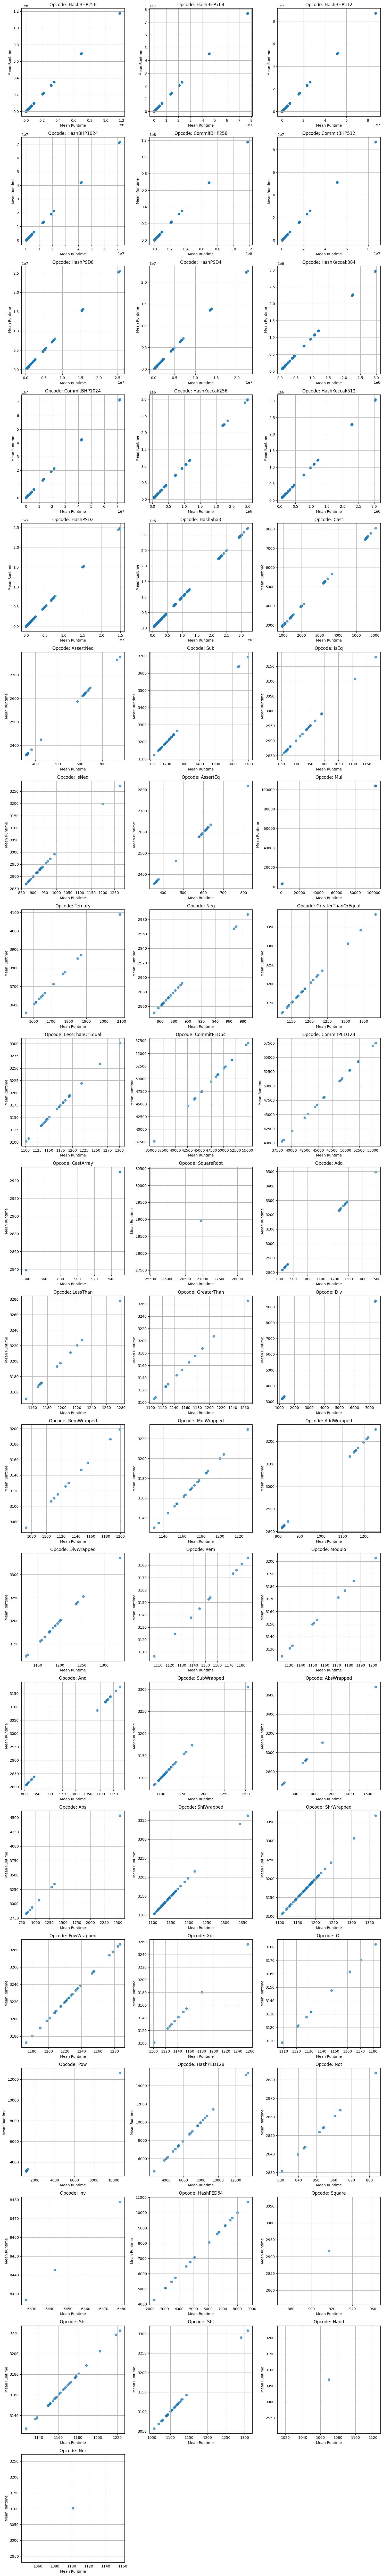

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the 'benchmarks' DataFrame already loaded

def extract_point_estimate(row):
    return row['mean']['point_estimate']

# Apply the function to create a new column with the extracted "point_estimate"
benchmarks['point_estimate'] = benchmarks.apply(extract_point_estimate, axis=1)

benchmarks['fee'] = benchmarks["point_estimate"] + 2000

# Get unique opcodes
unique_opcodes = benchmarks['opcode'].unique()

# Define the layout of the grid
num_opcodes = len(unique_opcodes)
num_cols = 3  # Or any other number of columns you prefer
num_rows = num_opcodes // num_cols + (num_opcodes % num_cols > 0)

# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten in case of a single row

# Create a separate plot for each opcode
for i, opcode in enumerate(unique_opcodes):
    opcode_data = benchmarks[benchmarks['opcode'] == opcode]
    ax = axes[i]
    ax.scatter(opcode_data['point_estimate'], opcode_data['fee'], alpha=0.7)

    # Customize the plot
    ax.set_title(f'Opcode: {opcode}')
    ax.set_xlabel('Mean Runtime')
    ax.set_ylabel('Mean Runtime')
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


We also look at the standard deviations to discover that the potential deviation between runtimes may grow as the mean runtime of the opcodes grow.

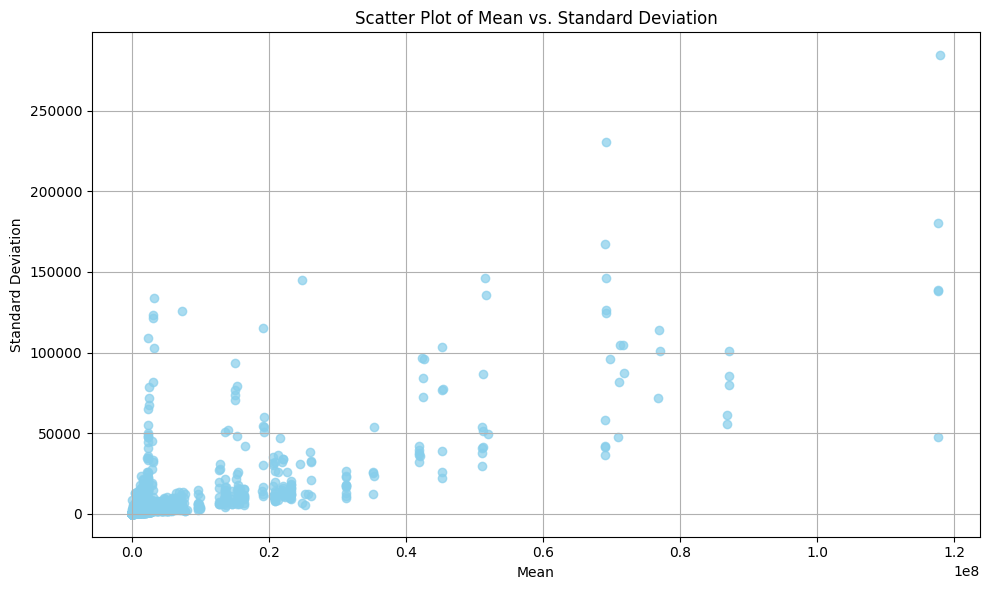

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your DataFrame named 'benchmarks' with the given structure
def extract_std_dev(row):
    return row['std_dev']['point_estimate']

# Apply the function to create a new column with the extracted "point_estimate"
benchmarks['std_dev'] = benchmarks.apply(extract_std_dev, axis=1)


# Extract the "point_estimate" (mean) and "standard_error" (standard deviation) columns
means = benchmarks['point_estimate']
std_devs = benchmarks['std_dev']

# Create a scatter plot with means on the x-axis and standard deviations on the y-axis
plt.figure(figsize=(10, 6))
plt.scatter(means, std_devs, c='skyblue', alpha=0.7)

# Customize the plot
plt.title('Scatter Plot of Mean vs. Standard Deviation')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Fitting Cost Equations for Hash & Commit Opcodes

To appropriately price expensive opcodes, regressions can be performed to provide ideas for what the base cost and cost per byte multipliers should be.

Below regressions are fit to the benchmark data on Commit and Hash opcodes to understand what these numbers might be.

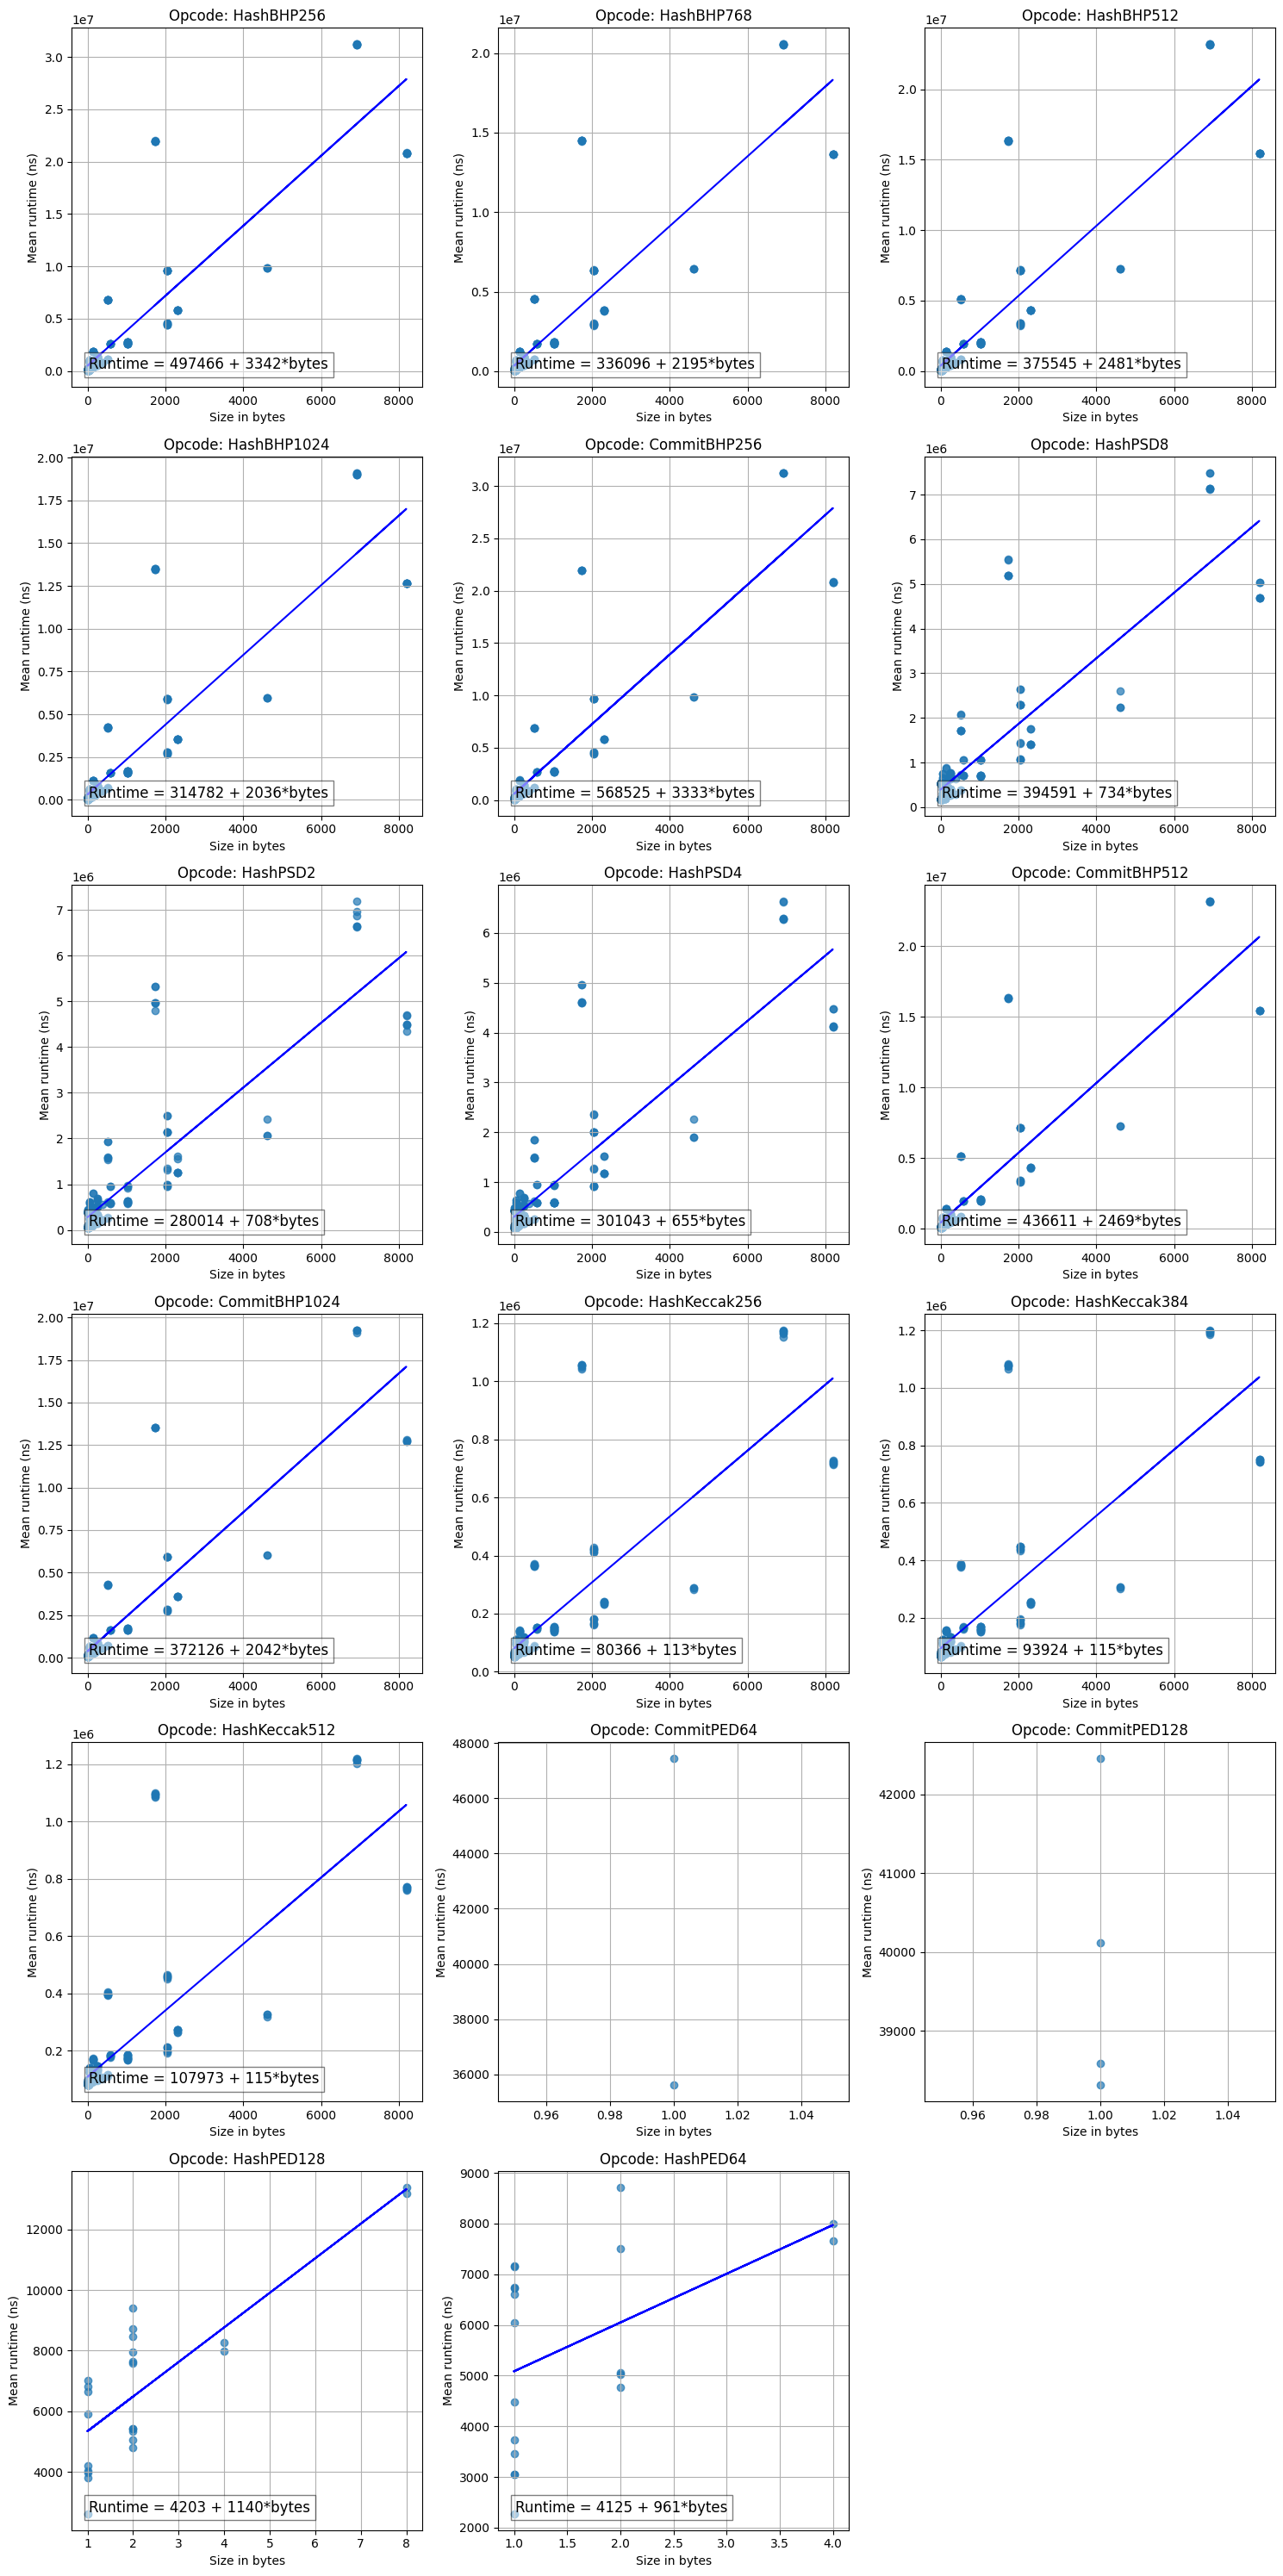

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Assuming you have the 'benchmarks' DataFrame already loaded

def extract_point_estimate(row):
    return row['mean']['point_estimate']

# Apply the function to create a new column with the extracted "point_estimate"
benchmarks['point_estimate'] = benchmarks.apply(extract_point_estimate, axis=1)

benchmarks['fee'] = benchmarks["point_estimate"] + 2000

# Get unique opcodes
unique_opcodes = benchmarks['opcode'].unique()

# Define the layout of the grid
num_opcodes = len(unique_opcodes)
num_cols = 3  # Or any other number of columns you prefer
num_rows = num_opcodes // num_cols + (num_opcodes % num_cols > 0)

benchmarks = benchmarks.dropna(subset=['size_in_bytes'])
benchmarks = benchmarks.dropna(subset=['point_estimate'])
benchmarks = benchmarks[benchmarks['size_in_bytes'] <= 8192]
benchmarks = benchmarks[benchmarks['opcode'].str.contains('Hash|Commit', na=False)]


# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten in case of a single row

# Create a separate plot for each opcode
for i, opcode in enumerate(unique_opcodes):
    opcode_data = benchmarks[benchmarks['opcode'] == opcode]
    opcode_data = opcode_data.dropna(subset=['point_estimate'])
    opcode_data = opcode_data[opcode_data['opcode'].str.contains('Hash|Commit', na=False)]
    ax = axes[i]
    ax.scatter(opcode_data['size_in_bytes'], opcode_data['point_estimate'], alpha=0.7)

    # Model the regression
    X = sm.add_constant(opcode_data['size_in_bytes'])  # Adds a constant term to the predictor
    model = sm.OLS(opcode_data['point_estimate'], X.astype(float)).fit()

    # Get the regression parameters and plit the equation
    if len(model.params) >= 2:
      a = int(model.params[0])  # Intercept
      b = int(model.params[1])  # Slope (Coefficient of X)
        # Get the equation and add it to the plot
      regression_equation = f"Runtime = {a} + {b}*bytes"

      # Get current limits of the plot
      x_lim = ax.get_xlim()
      y_lim = ax.get_ylim()

      # For example, 5% above the bottom and 5% from the left
      x_pos = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
      y_pos = y_lim[0] + (y_lim[1] - y_lim[0]) * 0.05

      ax.text(x_pos, y_pos, regression_equation, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))



    # Plot the regression
    Y_Pred = model.predict(X.astype(float))
    ax.plot(opcode_data['size_in_bytes'], Y_Pred, color='blue', label='regression')

    # Customize the plot
    ax.set_title(f'Opcode: {opcode}')
    ax.set_xlabel('Size in bytes')
    ax.set_ylabel('Mean runtime (ns)')
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The analysis above provides actionable numbers for pricing finalize block equations.

### Potential Idea: Penalize High Runtime Opcodes Nonlinearly

In order to discourage usage of the most compute intensive opcodes, one might use a pricing model that penalizes opcodes exponentially with an increasing # of input bytes. The figures below explore this pricing idea.

The argument against this approach is that it inherently applies selective judgment to what inputs are "good" and "bad" for the network and for this reason there is a strong argument for not using this approach.

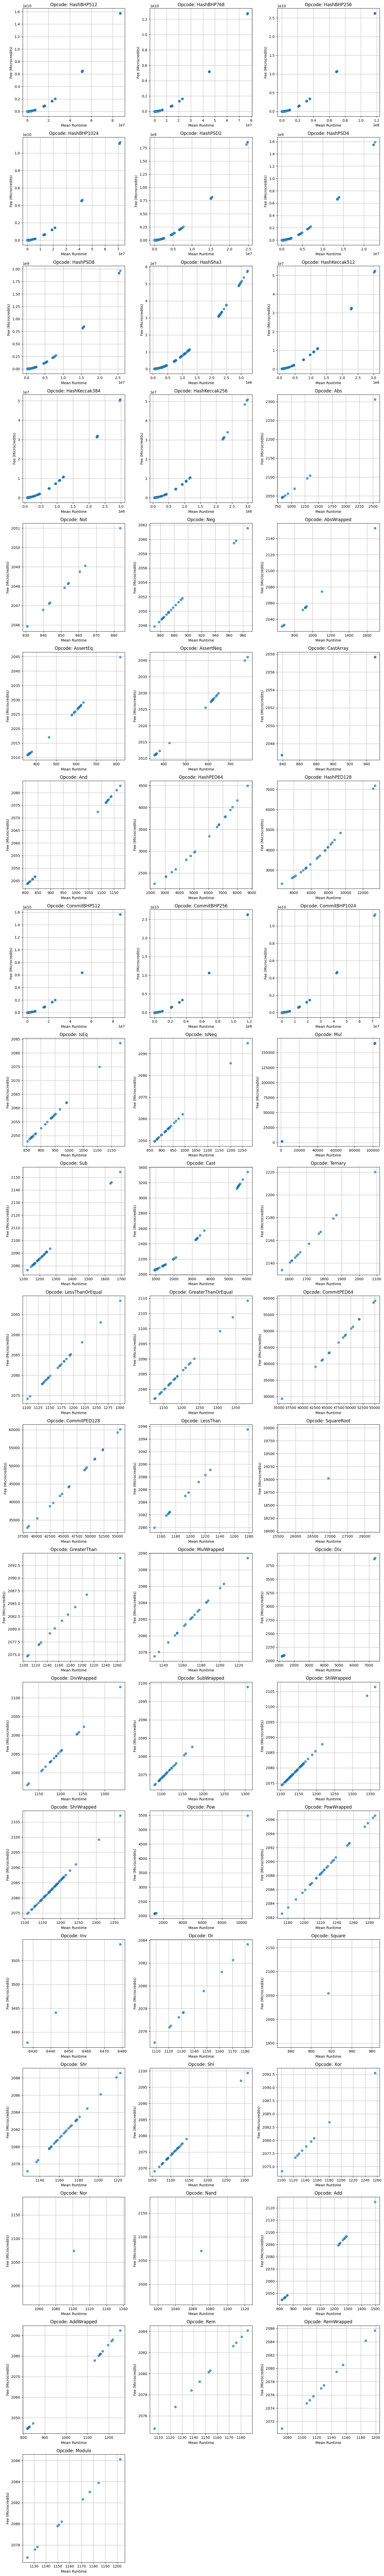

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the 'benchmarks' DataFrame already loaded

def extract_point_estimate(row):
    return row['mean']['point_estimate']

# Apply the function to create a new column with the extracted "point_estimate"
benchmarks['point_estimate'] = benchmarks.apply(extract_point_estimate, axis=1)

benchmarks['fee'] = (benchmarks["point_estimate"]**1.7 / 2000) + 2000

# Get unique opcodes
unique_opcodes = benchmarks['opcode'].unique()

# Define the layout of the grid
num_opcodes = len(unique_opcodes)
num_cols = 3  # Or any other number of columns you prefer
num_rows = num_opcodes // num_cols + (num_opcodes % num_cols > 0)

# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten in case of a single row

# Create a separate plot for each opcode
for i, opcode in enumerate(unique_opcodes):
    opcode_data = benchmarks[benchmarks['opcode'] == opcode]
    ax = axes[i]
    ax.scatter(opcode_data['point_estimate'], opcode_data['fee'], alpha=0.7)

    # Customize the plot
    ax.set_title(f'Opcode: {opcode}')
    ax.set_xlabel('Mean Runtime')
    ax.set_ylabel('Fee (Microcredits)')
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
